In [ ]:
import sys

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install --upgrade xgboost
    !pip install hyperopt
    !pip install imbalanced-learn


import xgboost
import warnings

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 49.3 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=0d15b6c19200bb73d7c3e82d3481e07b21599d97a7f7ae572e4090ceb67a76af
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 42 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import eli5
from eli5.sklearn import PermutationImportance
from hyperopt import hp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from ipywidgets import interact
from scipy.stats.distributions import uniform
from hyperopt import fmin, tpe, Trials, STATUS_OK
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/건강보험.CSV', encoding='euc-kr')
df.head()

,기준년도,가입자 일련번호,시도코드,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석,데이터 공개일자
0,2020,1,36,1,9,165,60,72.1,1.2,1.5,...,1.1,21.0,27.0,21.0,1.0,0.0,0,NaN,NaN,2021-12-29
1,2020,2,27,2,13,150,65,81.0,0.8,0.8,...,0.5,18.0,15.0,15.0,1.0,0.0,0,NaN,NaN,2021-12-29
2,2020,3,11,2,12,155,55,70.0,0.6,0.7,...,0.7,27.0,25.0,7.0,1.0,0.0,0,NaN,NaN,2021-12-29
3,2020,4,31,1,13,160,70,90.8,1.0,1.0,...,1.2,65.0,97.0,72.0,1.0,0.0,1,0.0,0.0,2021-12-29
4,2020,5,41,2,12,155,50,75.2,1.5,1.2,...,0.7,18.0,17.0,14.0,1.0,0.0,0,NaN,NaN,2021-12-29


In [ ]:
df["HCHK_YEAR"].value_counts()

KeyError: ignored

# Part 1.  Data Preprocessing

## 컬럼 설명



*   기준년도(HCHK_YEAR) : 해당 정보의 기준년도를 제공함
*   가입자 일련번호(IDV_ID) : 해당가입자의 부여한 일련번호
*   시도코드(SIDO) : 해당 수진자 거주지의 시도코드 
*   성별코드(SEX) : 해당 정보 대상자의 성별을 제공함 - 1(남자), 2(여자)
*   연령대 코드(5단위)(AGE_GROUP) : 기준년도에 수진자의 나이를 5세 단위로 그룹화(범주화)하여 구분한 코드
*   신장(5cm단위)(HEIGHT) : 검진자의 키
*   체중(5kg단위)(WEIGHT) : 검진자의 몸무게
*   허리둘레(WAIST) : 검진자의 허리둘레
*   시력(좌)(SIGHT_LEFT) : 수검자의 좌측 눈의 시력
*   시력(우)(SIGHT_RIGHT) : 수검자의 우측 눈의 시력
*   청력(좌)(HEAR_LEFT) : 수검자의 좌측 귀의 청력
*   청력(우)(HEAR_RIGHT) : 수검자의 우측 귀의 청력
*   수축기혈압(BP_HIGH) : 검진자의 최고 혈압으로 심장이 수축해서 강한 힘으로 혈액을 동맥에 보낼 때의 혈관 내압
*   이완기혈압(BP_LWST) : 검진자의 최저 혈압으로 심장의 완기시의 혈압
*   식전혈당(공복혈당)(BLDS) : 검진자 식사 전 혈당(혈액 100ml당 함유 되어 있는 포도당의 농도) 수치
*   총 콜레스테롤(TOT_CHOLE) : 혈청 중의 에스텔형, 비에스테형(유리)콜레스테롤의 합
*   트리글리세라이드(TRIGLYCERIDE) : 단순지질 혹은 중성지질을 뜻함
*   HDL 콜레스테롤(HDL_CHOLE) : HDL(고밀도 리포단백질)에 포함되는 콜레스테롤
*   LDL 콜레스테롤(LDL_CHOLE) : LDL(저밀도 리포단백질)에 함유된 콜레스테롤 
*   혈색소(HMG) : 혈액이나 혈구 속에 존재하는 색소단백으로 글로빈(globin)과 엠(heme)으로 구성되며 혈중의 산소운반체로서의 역할 수행
*   요단백(OLIG_PROTE_CD) : 소변에 단백질이 섞여 나오는 것
*   혈청크레아티닌(CREATININE) : 크레아티닌은 크레아틴의 탈수물로 내인성 단백대사의 종말산물로서 신장에서 배설되고 그 증감은 음식물에 관계없이 근육의 발육과 운동에 관계함
*   (혈청지오티)AST(SGOT_AST) : 간 기능을 나타내는 혈액검사상의 수치, 간세포 이외에 신장, 뇌, 근육 등에도 존재하는 효소로 이러한 세포들이 손상을 받는 경우 농도가 증가함
*   (혈청지오티)ALT(SGPT_ALT) : 간 기능을 나타내는 혈액검사상의 수치, ALT는 주로 간세포 안에 존재하는 효소로, 간세포가 손상을 받는 경우 농도가 증가함
*   감마 지티피(GAMMA_GTP) : 간 기능을 나타내는 혈액검사상의 수치, 간 낸의 쓸개관(담관)에 존재하는 효소로 글루타민산을 외부에 펩티드나 아미노산 등으로 옮기는 작용을 함. 쓸게즙(담즙) 배설 장애, 간세포 장애 발생 시 혈중이 증가하게 됨.
*   흡연상태(SMK_STAT_TYPE_CD) : 해당 수검자의 흡연 상태 여부
*   음주여부(DRK_YN) : 해당 수검자의 음주 상태 여부
*   구강검진 수검여부(HCHK_OE_INSPEC_YN) : 해당 검진자가 구강검진을 선택하여 검진하였는지 여부에 대한 항목
*   치아우식증유무(CRS_YN) : 해당 수검자의 치아우식증 유무에 대한 항목
*   치석(TTR_YN) : 해당 수검자의 치석 여부
*   데이터 공개일자(DATA_STD__DT) : 데이터 작성 기준일자


##1.1 EDA

In [ ]:
df.shape

(1000000, 31)

In [ ]:
df.columns

Index(['기준년도', '가입자 일련번호', '시도코드', '성별코드', '연령대 코드(5세단위)', '신장(5Cm단위)',
       '체중(5Kg 단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기 혈압',
       '이완기 혈압', '식전혈당(공복혈당)', '총 콜레스테롤', '트리글리세라이드', 'HDL 콜레스테롤', 'LDL 콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마 지티피', '흡연상태',
       '음주여부', '구강검진 수검여부', '치아우식증유무', '치석', '데이터 공개일자'],
      dtype='object')

In [ ]:
def analysis_on_features(df):

  eda_results = pd.DataFrame()
  eda_results['dtypes'] = df.dtypes
  eda_results['null_count'] = df.isnull().sum()
  eda_results['num_unique_values'] = df.nunique()
  duplicated_rows = df[df.duplicated()]

  return eda_results, duplicated_rows

In [ ]:
df.columns = ['HCHK_YEAR', 'IDV_ID', 'SIDO', 'SEX', 'AGE_GROUP', 'HEIGHT', 'WEIGHT', 'WAIST' , 'SIGHT_LEFT', 'SIGHT_RIGHT', 'HEAR_LEFT', 'HEAR_RIGHT', 'BP_HIGH', 'BP_LWST', 'BLDS', 'TOT_CHOLE', 'TRIGLYCERIDE', 'HDL_CHOLE', 'LDL_CHOLE', 'HMG', 'OLIG_PROTE_CD', 'CREATININE', 'SGOT_AST', 'SGPT_ALT', 'GAMMA_GTP', 'SMK_STAT_TYPE_CD', 'DRK_YN', 'HCHK_OE_INSPEC_YN', 'CRS_YN', 'TTR_YN', 'DATA_STD__DT']

In [ ]:
df_results

NameError: ignored

In [ ]:
df_results, df_duplicated_rows = analysis_on_features(df)
print(f"df: duplicated? = {df_duplicated_rows}\n", df_results)

df: duplicated? = Empty DataFrame
Columns: [HCHK_YEAR, IDV_ID, SIDO, SEX, AGE_GROUP, HEIGHT, WEIGHT, WAIST, SIGHT_LEFT, SIGHT_RIGHT, HEAR_LEFT, HEAR_RIGHT, BP_HIGH, BP_LWST, BLDS, TOT_CHOLE, TRIGLYCERIDE, HDL_CHOLE, LDL_CHOLE, HMG, OLIG_PROTE_CD, CREATININE, SGOT_AST, SGPT_ALT, GAMMA_GTP, SMK_STAT_TYPE_CD, DRK_YN, HCHK_OE_INSPEC_YN, CRS_YN, TTR_YN, DATA_STD__DT]
Index: []

[0 rows x 31 columns]
                     dtypes  null_count  num_unique_values
HCHK_YEAR            int64           0                  1
IDV_ID               int64           0            1000000
SIDO                 int64           0                 17
SEX                  int64           0                  2
AGE_GROUP            int64           0                 10
HEIGHT               int64           0                 14
WEIGHT               int64           0                 22
WAIST              float64         108                777
SIGHT_LEFT         float64         257                 24
SIGHT_RIGHT        fl

In [ ]:
df.corr().style.background_gradient(cmap = "magma")

,HCHK_YEAR,IDV_ID,SIDO,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTR_YN
HCHK_YEAR,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
IDV_ID,nan,1.000000,0.000183,-0.001267,0.000881,0.001424,0.000898,0.000668,-0.000138,0.000834,0.000342,0.000985,0.000859,0.001857,0.000614,-0.003119,-0.002842,0.000106,-0.002139,0.001265,0.002201,0.001266,-0.000327,0.000344,0.000451,0.000148,0.000900,0.000765,-0.001615,-0.000100
SIDO,nan,0.000183,1.000000,-0.019381,-0.003828,-0.005453,0.011615,0.011126,0.017687,0.017713,0.001512,0.001049,0.019389,0.018916,0.005827,-0.007456,0.015849,-0.021593,-0.004773,0.005873,-0.016139,-0.006148,0.004800,0.006232,0.009917,0.011840,-0.034525,-0.019702,0.031244,-0.001573
SEX,nan,-0.001267,-0.019381,1.000000,0.065388,-0.720695,-0.553887,-0.404275,-0.080349,-0.084341,-0.010057,-0.005594,-0.116329,-0.176693,-0.129612,0.072455,-0.193679,0.269239,0.049118,-0.618036,-0.043821,-0.321725,-0.066353,-0.168123,-0.235968,-0.596244,-0.325499,-0.068384,-0.041983,-0.048653
AGE_GROUP,nan,0.000881,-0.003828,0.065388,1.000000,-0.365121,-0.235258,0.098477,-0.155089,-0.147627,0.223054,0.218556,0.229686,-0.030582,0.114715,-0.179331,-0.058088,-0.077344,-0.148437,-0.158264,0.024181,0.046580,0.030282,-0.060127,-0.057309,-0.162729,-0.335340,-0.115081,-0.068458,-0.085002
HEIGHT,nan,0.001424,-0.005453,-0.720695,-0.365121,1.000000,0.661926,0.327558,0.113394,0.113258,-0.077046,-0.078484,0.004569,0.133519,0.058632,-0.000263,0.148775,-0.170868,0.010629,0.490852,0.024544,0.224141,0.027489,0.131465,0.165648,0.476120,0.355115,0.082205,0.035662,0.044720
WEIGHT,nan,0.000898,0.011615,-0.553887,-0.235258,0.661926,1.000000,0.784041,0.075184,0.074312,-0.050075,-0.051380,0.191802,0.257129,0.157241,-0.000432,0.266429,-0.294161,0.006121,0.459787,0.049407,0.192722,0.073845,0.237981,0.194396,0.355304,0.252780,0.061033,0.038551,0.051578
WAIST,nan,0.000668,0.011126,-0.404275,0.098477,0.327558,0.784041,1.000000,0.006084,0.007180,0.035000,0.032190,0.275676,0.242307,0.213131,-0.049447,0.259686,-0.314286,-0.040464,0.343790,0.066239,0.163416,0.091252,0.222426,0.191817,0.242004,0.099154,0.024158,0.023517,0.044684
SIGHT_LEFT,nan,-0.000138,0.017687,-0.080349,-0.155089,0.113394,0.075184,0.006084,1.000000,0.281132,-0.035169,-0.034290,-0.031905,0.015523,-0.024412,0.023026,0.017537,-0.001549,0.019852,0.069762,-0.005537,0.014417,-0.003730,0.017242,0.016803,0.056288,0.069715,0.006555,0.009887,0.011949
SIGHT_RIGHT,nan,0.000834,0.017713,-0.084341,-0.147627,0.113258,0.074312,0.007180,0.281132,1.000000,-0.030699,-0.028233,-0.030420,0.014267,-0.023774,0.020664,0.018780,-0.005368,0.018730,0.070771,-0.005484,0.018797,-0.003068,0.016227,0.018325,0.055614,0.066594,0.002138,0.013118,0.011218


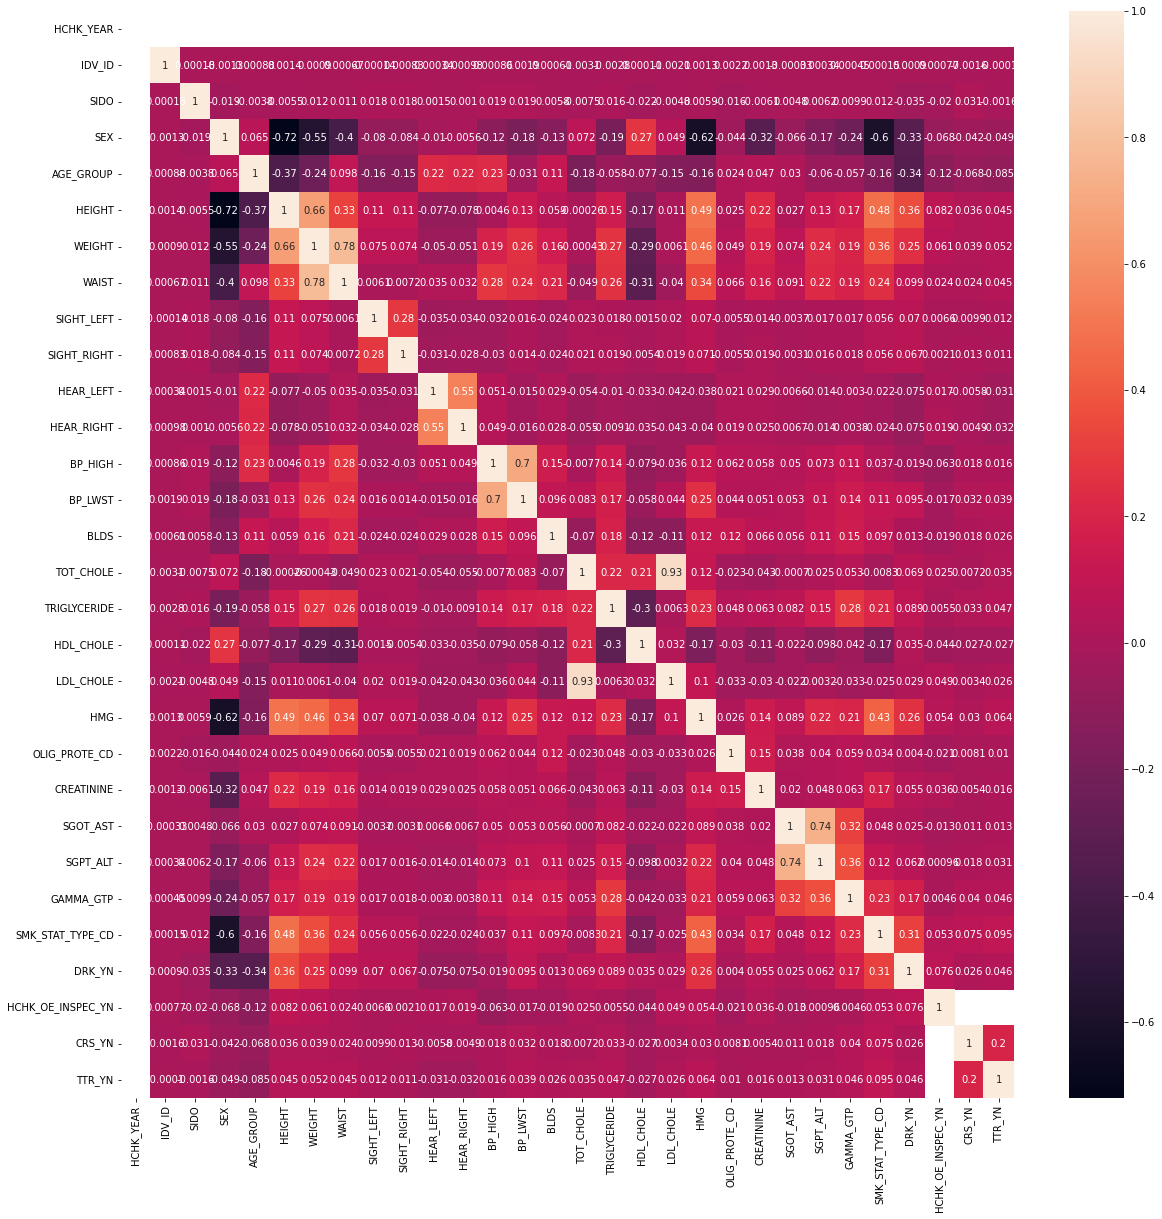

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize= (20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()
plt.clf()

타겟데이터의 비율
 11    0.175705
9     0.156277
13    0.155096
10    0.144165
12    0.142089
14    0.086653
15    0.073714
16    0.036663
17    0.023401
18    0.006237
Name: AGE_GROUP, dtype: float64


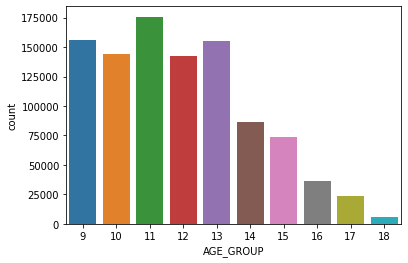

In [ ]:
print("타겟데이터의 비율\n", df['AGE_GROUP'].value_counts(normalize=True))


%matplotlib inline
sns.countplot(x=df['AGE_GROUP']);

타겟데이터의 비율
 1.0    0.5848
0.0    0.4152
Name: DRK_YN, dtype: float64


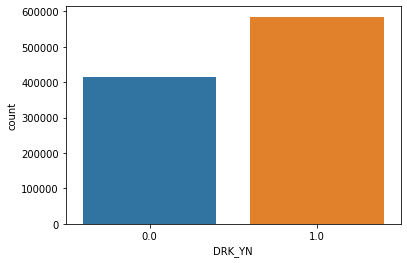

In [ ]:
print("타겟데이터의 비율\n", df['DRK_YN'].value_counts(normalize=True))


%matplotlib inline
sns.countplot(x=df['DRK_YN']);

In [ ]:
target = 'DRK_YN'
n_zero_label = df[target].value_counts().loc[0]
n_zero_label

415119

타겟데이터의 비율
 1    0.510689
2    0.489311
Name: SEX, dtype: float64


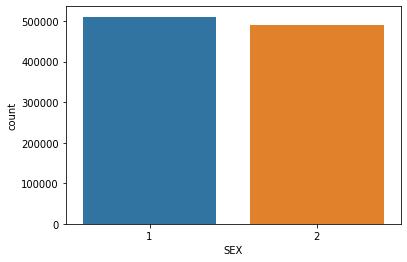

In [ ]:
print("타겟데이터의 비율\n", df['SEX'].value_counts(normalize=True))


%matplotlib inline
sns.countplot(x=df['SEX']);

In [ ]:
def analysis_on_target(df):
  
  target = 'DRK_YN'
  n_zero_label = df[target].value_counts().loc[0]
  n_one_label = df[target].value_counts().loc[1]

  plt.pie(
      (n_zero_label, n_one_label),
      labels=(0, 1),
      autopct="%.2f%%",
      shadow=True,
      startangle=90,
  )
  plt.title("Target: DRK_YN", size=15)
  plt.show()
  
  return n_zero_label, n_one_label

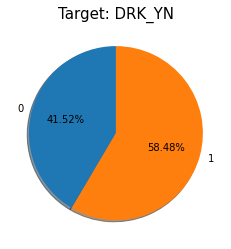

In [ ]:
df_label_count = analysis_on_target(df)

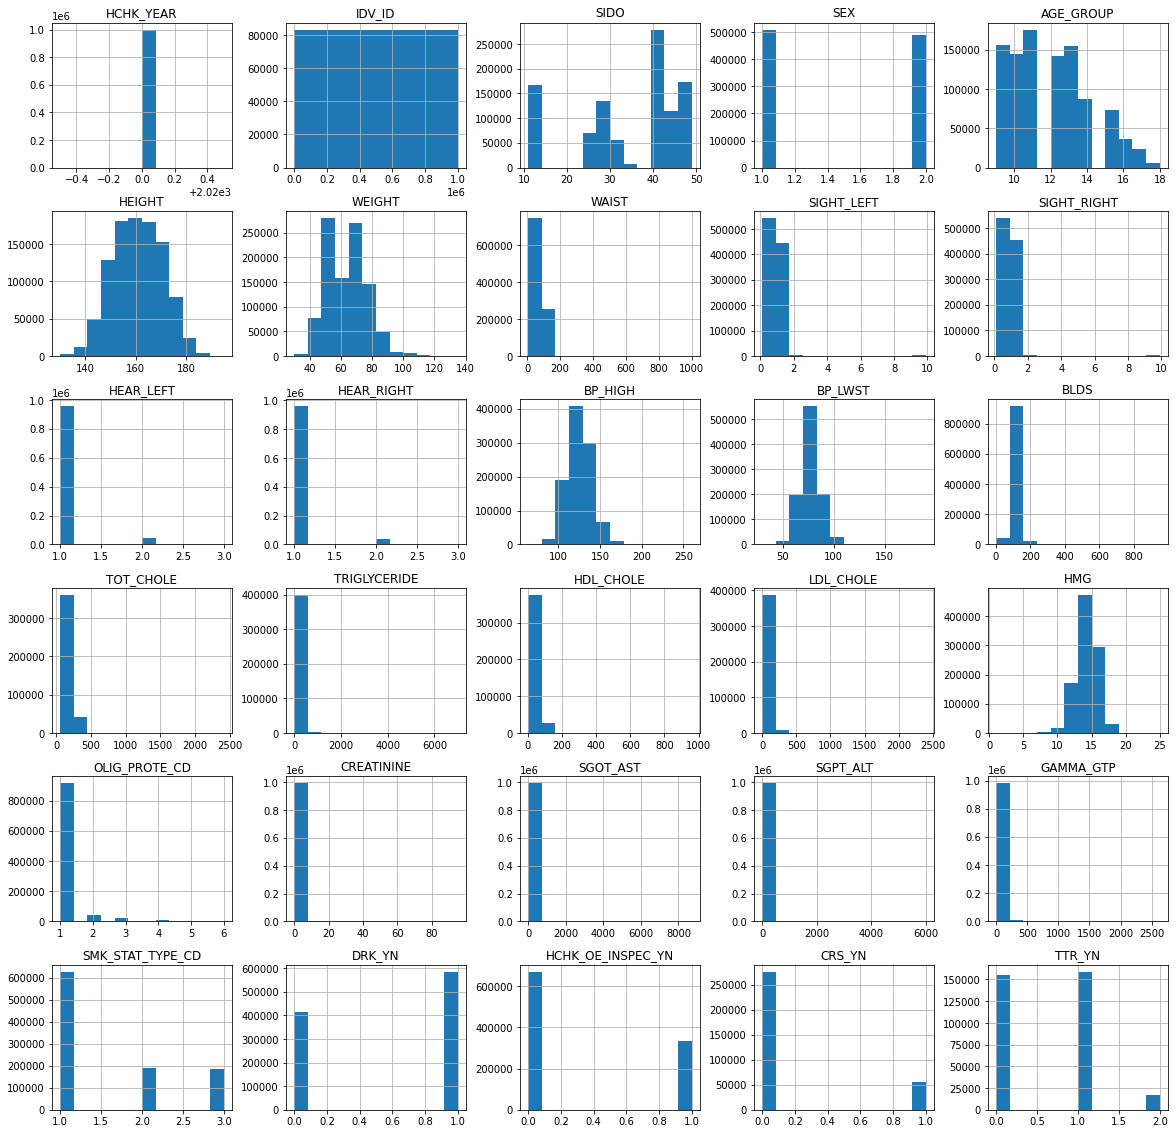

In [ ]:
df.hist(figsize = (20, 20), bins = 12, legend = False);

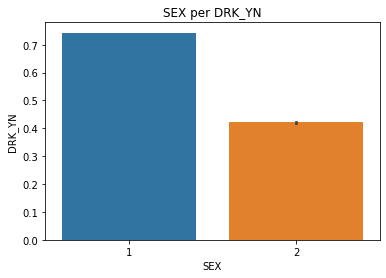

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.barplot(x='SEX', y='DRK_YN', data=df)
plt.title(f'SEX per DRK_YN')
plt.show()
plt.clf()

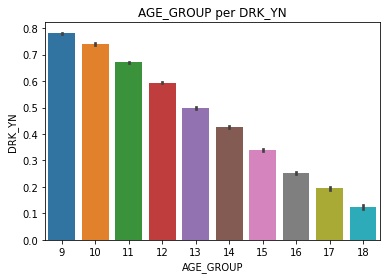

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.barplot(x='AGE_GROUP', y='DRK_YN', data=df)
plt.title(f'AGE_GROUP per DRK_YN')
plt.show()
plt.clf()

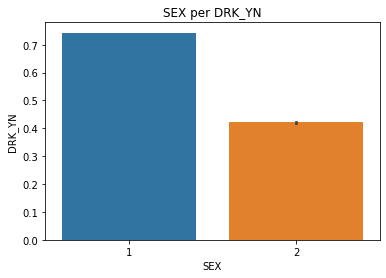

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.barplot(x='SEX', y='DRK_YN', data=df)
plt.title(f'SEX per DRK_YN')
plt.show()
plt.clf()

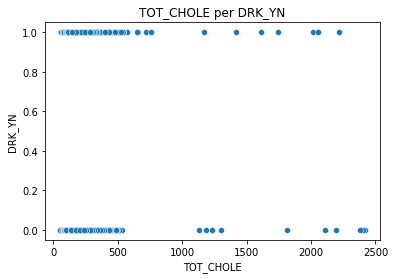

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.scatterplot(x='TOT_CHOLE', y='DRK_YN', data=df)
plt.title(f'TOT_CHOLE per DRK_YN')
plt.show()
plt.clf()

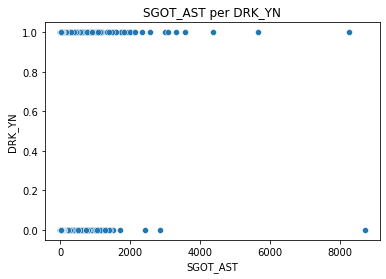

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.scatterplot(x='SGOT_AST', y='DRK_YN', data=df)
plt.title(f'SGOT_AST per DRK_YN')
plt.show()
plt.clf()

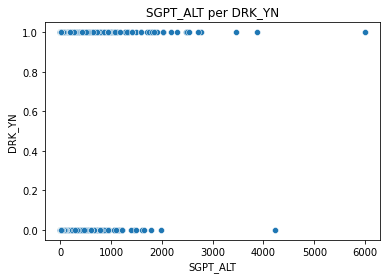

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.scatterplot(x='SGPT_ALT', y='DRK_YN', data=df)
plt.title(f'SGPT_ALT per DRK_YN')
plt.show()
plt.clf()

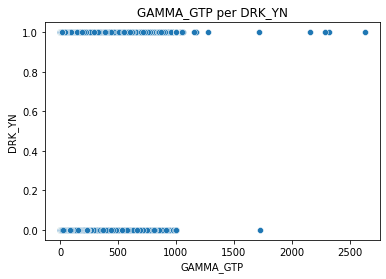

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.scatterplot(x='GAMMA_GTP', y='DRK_YN', data=df)
plt.title(f'GAMMA_GTP per DRK_YN')
plt.show()
plt.clf()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   HCHK_YEAR          1000000 non-null  int64  
 1   IDV_ID             1000000 non-null  int64  
 2   SIDO               1000000 non-null  int64  
 3   SEX                1000000 non-null  int64  
 4   AGE_GROUP          1000000 non-null  int64  
 5   HEIGHT             1000000 non-null  int64  
 6   WEIGHT             1000000 non-null  int64  
 7   WAIST              999892 non-null   float64
 8   SIGHT_LEFT         999743 non-null   float64
 9   SIGHT_RIGHT        999748 non-null   float64
 10  HEAR_LEFT          999778 non-null   float64
 11  HEAR_RIGHT         999770 non-null   float64
 12  BP_HIGH            992468 non-null   float64
 13  BP_LWST            992466 non-null   float64
 14  BLDS               992398 non-null   float64
 15  TOT_CHOLE          402306 non-nul

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HCHK_YEAR,1000000.0,2020.000000,0.000000,2020.0,2020.00,2020.0,2020.00,2020.0
IDV_ID,1000000.0,500000.500000,288675.278933,1.0,250000.75,500000.5,750000.25,1000000.0
SIDO,1000000.0,34.047725,12.443883,11.0,27.00,41.0,44.00,49.0
SEX,1000000.0,1.489311,0.499886,1.0,1.00,1.0,2.00,2.0
AGE_GROUP,1000000.0,11.917757,2.171036,9.0,10.00,12.0,13.00,18.0
HEIGHT,1000000.0,160.964085,9.197899,130.0,155.00,160.0,170.00,195.0
WEIGHT,1000000.0,63.060790,12.269907,30.0,55.00,60.0,70.00,135.0
WAIST,999892.0,82.357094,9.622632,5.8,76.00,82.0,89.00,999.0
SIGHT_LEFT,999743.0,0.933045,0.637453,0.1,0.70,0.9,1.20,9.9
SIGHT_RIGHT,999748.0,0.935036,0.644911,0.1,0.70,0.9,1.20,9.9


## 1.2 Feature Engineering

In [ ]:
def eda_process(df):
  
  df.dropna(subset=['TOT_CHOLE'], how='any', axis=0, inplace=True)
  df.dropna(subset=['LDL_CHOLE'], how='any', axis=0, inplace=True)
  df.dropna(subset=['TTR_YN'], how='any', axis=0, inplace=True)
  df.dropna(subset=['OLIG_PROTE_CD'], how='any', axis=0, inplace=True)
  df.dropna(subset=['HMG'], how='any', axis=0, inplace=True)
  df.dropna(subset=['DRK_YN'], how='any', axis=0, inplace=True)
  df.dropna(subset=['SMK_STAT_TYPE_CD'], how='any', axis=0, inplace=True)
  df.dropna(subset=['BP_HIGH'], how='any', axis=0, inplace=True)
  df.dropna(subset=['SGPT_ALT'], how='any', axis=0, inplace=True)
  
  
  df.drop(columns=['HCHK_YEAR', 'IDV_ID', 'SIDO', 'DATA_STD__DT', 'HCHK_OE_INSPEC_YN', 'CRS_YN'], axis=1, inplace=True)
  df.drop(columns=['SMK_STAT_TYPE_CD', 'SIGHT_LEFT', 'SIGHT_RIGHT', 'HEAR_LEFT', 'HEAR_RIGHT'], axis=1, inplace=True)
  
  df.drop(columns=['HEIGHT', 'WEIGHT', 'WAIST'], axis=1, inplace=True)

  df = df[df['AGE_GROUP'] <= 13]
  df.reset_index(drop=True, inplace=True)

  return df

In [ ]:
df_processed = eda_process(df.copy())
df_processed.shape

(103662, 17)

In [ ]:
df_processed.isnull().sum()

SEX              0
AGE_GROUP        0
BP_HIGH          0
BP_LWST          0
BLDS             0
TOT_CHOLE        0
TRIGLYCERIDE     0
HDL_CHOLE        0
LDL_CHOLE        0
HMG              0
OLIG_PROTE_CD    0
CREATININE       0
SGOT_AST         0
SGPT_ALT         0
GAMMA_GTP        0
DRK_YN           0
TTR_YN           0
dtype: int64

In [ ]:
df_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
SEX,103662.0,1.472960,0.499271,1.00,1.0,1.0,2.0,2.0
AGE_GROUP,103662.0,10.910758,1.579249,9.00,9.0,11.0,13.0,13.0
BP_HIGH,103662.0,122.032760,13.935062,70.00,112.0,121.0,131.0,260.0
BP_LWST,103662.0,76.323995,9.818133,38.00,70.0,76.0,82.0,144.0
BLDS,103662.0,101.987151,22.262973,50.00,91.0,97.0,106.0,495.0
TOT_CHOLE,103662.0,202.651502,39.499941,54.00,176.0,201.0,228.0,517.0
TRIGLYCERIDE,103662.0,126.183413,70.412024,5.00,75.0,108.0,159.0,399.0
HDL_CHOLE,103662.0,56.503723,14.349932,2.00,46.0,55.0,65.0,545.0
LDL_CHOLE,103662.0,121.234686,36.658592,1.00,96.0,120.0,144.0,1512.0
HMG,103662.0,14.331649,1.526363,4.20,13.3,14.4,15.4,21.9


# Part 2. Modeling

##2.1 데이터 분할

In [ ]:
def divide_data(df):
  X = df.drop(labels=target, axis=1)
  y = df[target]
  return X, y

In [ ]:
target = 'DRK_YN'

X, y = divide_data(df_processed)
print(X.shape, y.shape)

(103662, 16) (103662,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X_train.shape: {X_train.shape}\nX_val.shape: {X_val.shape}\nX_test.shape: {X_test.shape}")

X_train.shape: (66343, 16)
X_val.shape: (16586, 16)
X_test.shape: (20733, 16)


## 2.2 Baseline 모델

In [ ]:
base_major = y_train.mode(0)

y_pred_base = [base_major] * len(y_train)

print("training accuracy:", accuracy_score(y_train, y_pred_base).round(2))

training accuracy: 0.67


## 2.3 Feature Scaled

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_Scaled = scaler.transform(X_train)
X_val_Scaled = scaler.transform(X_val)
X_test_Scaled = scaler.transform(X_test)

## 2.4 Random Forest model

In [ ]:
model_rf = RandomForestClassifier(n_estimators = 1000, random_state=42, oob_score=True, n_jobs=-1)
model_rf.fit(X_train_Scaled, y_train)

print("훈련 정확도: ", model_rf.score(X_train_Scaled, y_train))
print("검증 정확도: ", model_rf.score(X_val_Scaled, y_val))

훈련 정확도:  1.0
검증 정확도:  0.7251296273965996


In [ ]:
pipe_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(max_depth = 20, random_state=42, oob_score=True, n_jobs=-1),
)

pipe_rf.fit(X_train_Scaled, y_train)
print("훈련 정확도: ", pipe_rf.score(X_train_Scaled, y_train))
print("검증 정확도: ", pipe_rf.score(X_val_Scaled, y_val))

훈련 정확도:  0.972039250561476
검증 정확도:  0.724406125648137


In [ ]:
y_pred = pipe_rf.predict(X_val_Scaled)
print("검증 정확도", pipe_rf.score(X_val_Scaled, y_val))

print(classification_report(y_val, y_pred))

검증 정확도 0.5513686241408416
              precision    recall  f1-score   support

         0.0       0.23      0.16      0.19      5475
         1.0       0.64      0.75      0.69     11111

    accuracy                           0.55     16586
   macro avg       0.44      0.45      0.44     16586
weighted avg       0.51      0.55      0.52     16586



### 2.4.1 Get Accuracy Score on Test Set

In [ ]:
y_pred = pipe_rf.predict(X_test_Scaled)
accuracy_score(y_test, y_pred)

0.7261370761587806

In [ ]:
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth = 10, random_state=42, oob_score=True, n_jobs=-1),
)

pipe_rf.fit(X_train, y_train)
print("훈련 정확도: ", pipe_rf.score(X_train, y_train))
print("검증 정확도: ", pipe_rf.score(X_val, y_val))

훈련 정확도:  0.754216722186214
검증 정확도:  0.7262148800192934


In [ ]:
pipe_rf.named_steps["randomforestclassifier"].oob_score_

0.7284415838897849

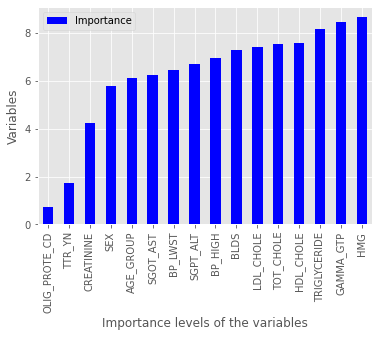

In [ ]:
importance = pd.DataFrame({"Importance": model_rf.feature_importances_ * 100},
                         index = pd.DataFrame(X_train).columns)
importance.sort_values(by = "Importance", axis = 0,
                       ascending = True).plot(kind = "bar", color = "blue")
plt.xlabel("Importance levels of the variables")
plt.ylabel("Variables");

In [ ]:
y_pred = pipe_rf.predict(X_val_Scaled)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.23      0.16      0.19      5475
         1.0       0.64      0.75      0.69     11111

    accuracy                           0.55     16586
   macro avg       0.44      0.45      0.44     16586
weighted avg       0.51      0.55      0.52     16586



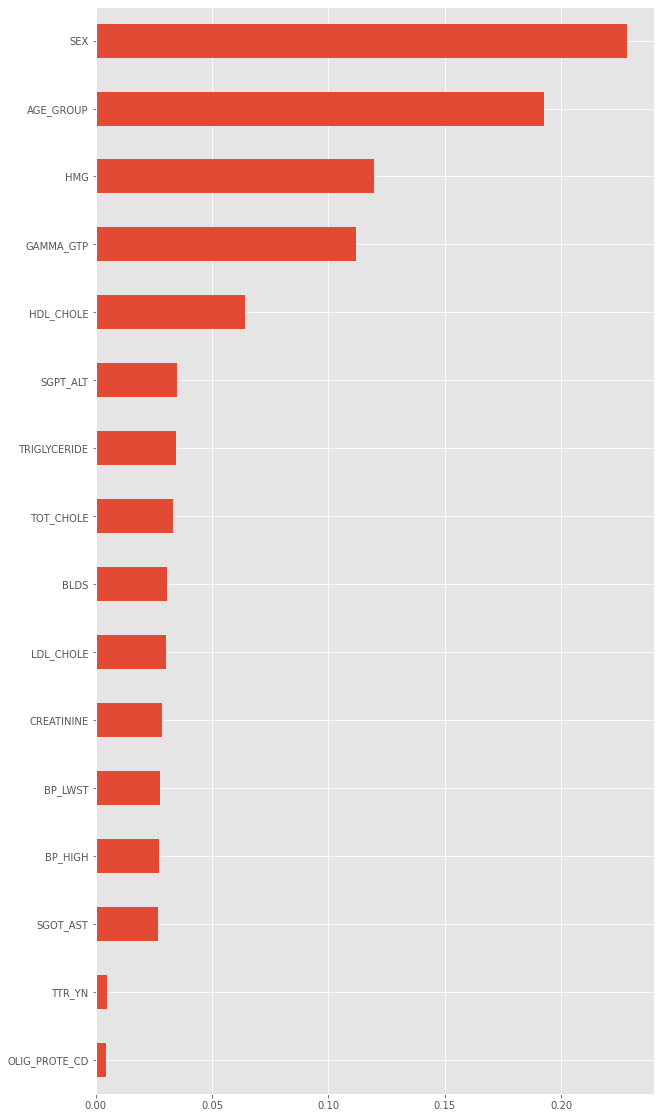

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

model_rf = pipe_rf.named_steps['randomforestclassifier']
importances = pd.Series(model_rf.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 20))
importances.sort_values().plot.barh();

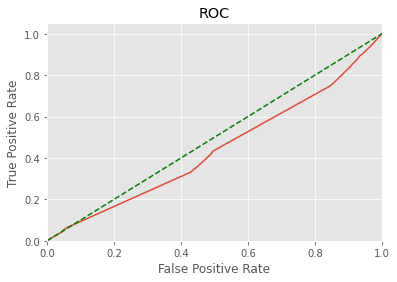

In [ ]:
rf_roc_auc = roc_auc_score(y_val, model_rf.predict(X_val_Scaled))
fpr, tpr, thresholds = roc_curve(y_val, model_rf.predict_proba(X_val_Scaled)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

[[ 861 4614]
 [2827 8284]]


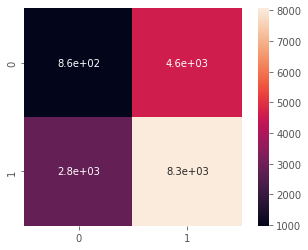

In [ ]:
conf_mat = confusion_matrix(y_val, y_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()

##XGB

In [ ]:
pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error", 
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=7,
        learning_rate=0.1,
    ),
)
print(pipe)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='error',
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=-1,
       

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='error',
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=7, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               predictor='auto', random_state=42, r

In [ ]:
from sklearn.metrics import classification_report

print("검증 정확도", pipe.score(X_val, y_val))

y_pred = pipe.predict(X_test)
print("일반화 성능:\n", classification_report(y_test, y_pred))

검증 정확도 0.724406125648137
일반화 성능:
               precision    recall  f1-score   support

         0.0       0.63      0.41      0.49      6861
         1.0       0.75      0.88      0.81     13872

    accuracy                           0.72     20733
   macro avg       0.69      0.64      0.65     20733
weighted avg       0.71      0.72      0.71     20733



##2.3 Tuning 

In [ ]:
def fit(X_train, y_train):
  
  pipeline = make_pipeline(
      SimpleImputer(),
      XGBClassifier(),
  )

  params = {
      "simpleimputer__strategy": ["median", "mean"],
      "xgbclassifier__max_depth": [2, 4, 6],
      "xgbclassifier__min_child_weight": [2, 4, 8],
      "xgbclassifier__colsample_bytree": uniform(loc=0.5, scale=0.5)

  }

  clf = RandomizedSearchCV(
      pipeline,
      param_distributions=params,
      scoring='roc_auc',
      n_iter=10,
      cv=3,
      verbose=3,
      random_state=42,
  )

  clf.fit(X_train, y_train)
  print("Optimal Hyperparmeter:", clf.best_params_)
  print("AUC:", clf.best_score_)

  return clf

def predict(X, y, best_estimator):
  y_pred_proba = best_estimator.predict_proba(X)[:,1]

  report = classification_report(y, y_pred_proba > 0.5)
  return y_pred_proba, report

In [ ]:
clf = fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.744 total time=   4.4s
[CV 2/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.748 total time=   4.2s
[CV 3/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.744 total time=   4.2s
[CV 1/3] END simpleimputer__strategy=mean, xgbclassifier__colsample_bytree=0.7993292420985183, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=4;, score=0.746 total time=   3.9s
[CV 2/3] END simpleimputer__strategy=mean, xgbclassifier__colsample_bytree=0.7993292420985183, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=4;, score=0.747 to

일반화 성능:
               precision    recall  f1-score   support

         0.0       0.65      0.40      0.50      6861
         1.0       0.75      0.89      0.82     13872

    accuracy                           0.73     20733
   macro avg       0.70      0.65      0.66     20733
weighted avg       0.72      0.73      0.71     20733



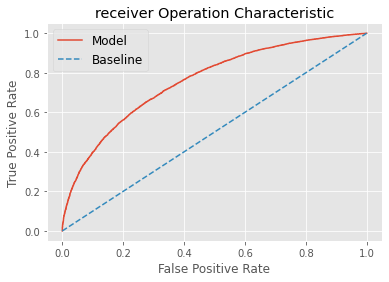

In [ ]:
def plot_roc(y, y_pred_proba):
  auc_score = roc_auc_score(y, y_pred_proba)
  fpr, tpr, _ = roc_curve(y, y_pred_proba)
  baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

  plt.style.use('ggplot')
  plt.plot(fpr, tpr, label="Model")
  plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
  plt.xlabel("False Positive Rate", size=12)
  plt.ylabel("True Positive Rate", size=12)
  plt.title("receiver Operation Characteristic")
  plt.legend(prop={"size": 12})
  plt.show()
  return auc_score

y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print("일반화 성능:\n", report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [ ]:
print("Test AUC:", auc_score)

Test AUC: 0.7588637455204996


#Part 3. Visualization

In [ ]:
pipeline = clf.best_estimator_

preprocess_pipeline = pipeline[:1]
model = pipeline[1:]

X_val_preprocessed = preprocess_pipeline.transform(X_val)

In [ ]:
def get_permuation_importance(X, y, model):
  
  permuter = PermutationImportance(
      model.named_steps['xgbclassifier'],
      scoring='roc_auc',
      n_iter=5,
      random_state=42
  )

  permuter.fit(X, y)

  return permuter

In [ ]:
permuter = get_permuation_importance(X_val_preprocessed, y_val, model)
eli5.show_weights(permuter, top=None, feature_names=X_val.columns.tolist())
print("Top3 Important Features:")
p_i = sorted(
    list(zip(X_val.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:10])

Top3 Important Features:
[('GAMMA_GTP', 0.10344672217033471), ('AGE_GROUP', 0.04737434117802075), ('SGPT_ALT', 0.044500981145426464), ('HDL_CHOLE', 0.03644419660125431), ('SGOT_AST', 0.019822663519400808), ('TRIGLYCERIDE', 0.006118629236184447), ('LDL_CHOLE', 0.002929410634419116), ('HMG', 0.0025075930372850273), ('CREATININE', 0.002077250897307725), ('BP_LWST', 0.0020278969129805978)]


In [ ]:
def get_pdp_isolated(dataset, model, feature):

  pdp_isolated = pdp_isolate(
      model=model,
      dataset=dataset,
      model_features = dataset,
      feature=feature,
      grid_type="percentile",
      num_grid_points=10
  )

  return pdp_isolated

In [ ]:
X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=X_val.columns)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b173229d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b17378a10>})

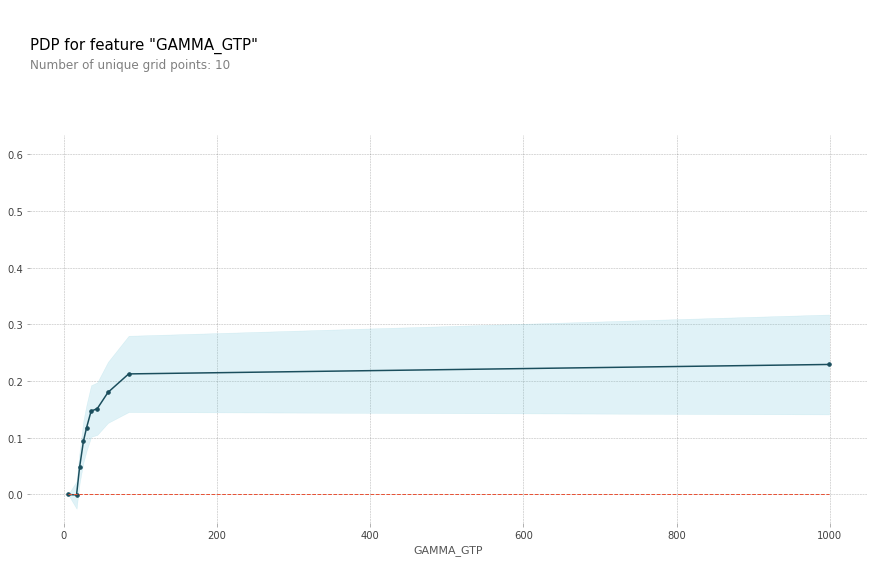

In [ ]:
target_feature = "GAMMA_GTP"

isolated = pdp_isolate(
    model=model,
    dataset=X_val_preprocessed_df,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b17475150>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b17f89390>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b174db310>}})

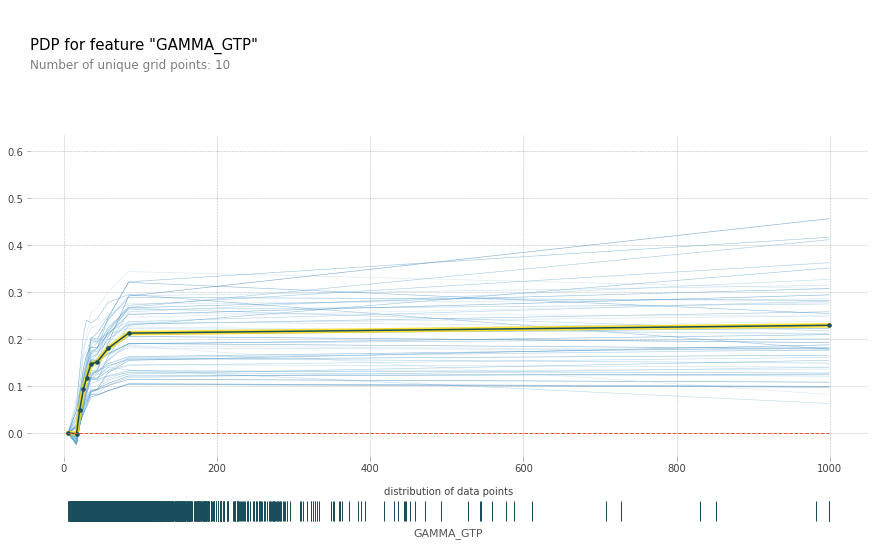

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18bee810>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18bee550>})

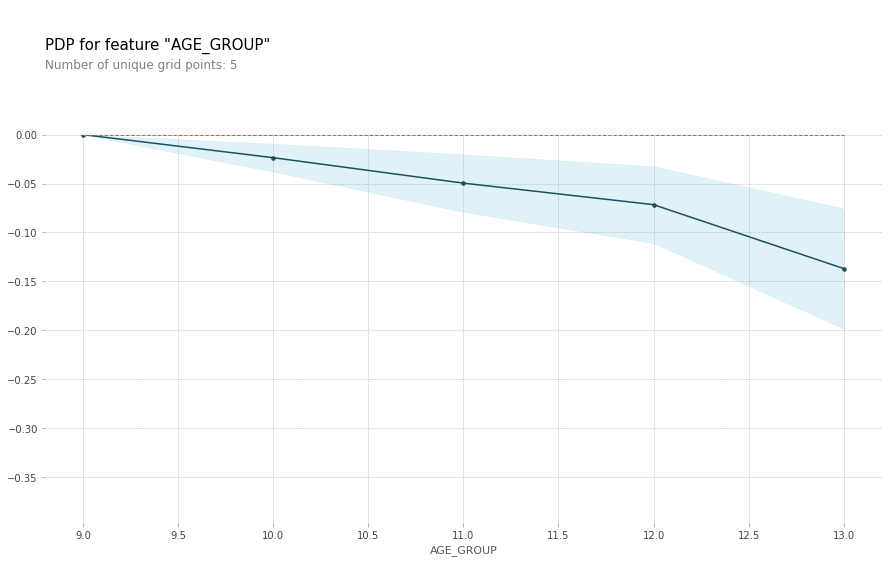

In [ ]:
target_feature = "AGE_GROUP"

isolated = pdp_isolate(
    model=model,
    dataset=X_val_preprocessed_df,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile", 
    num_grid_points=10,  
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b1823dad0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bba8a65d0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b1cf2f4d0>}})

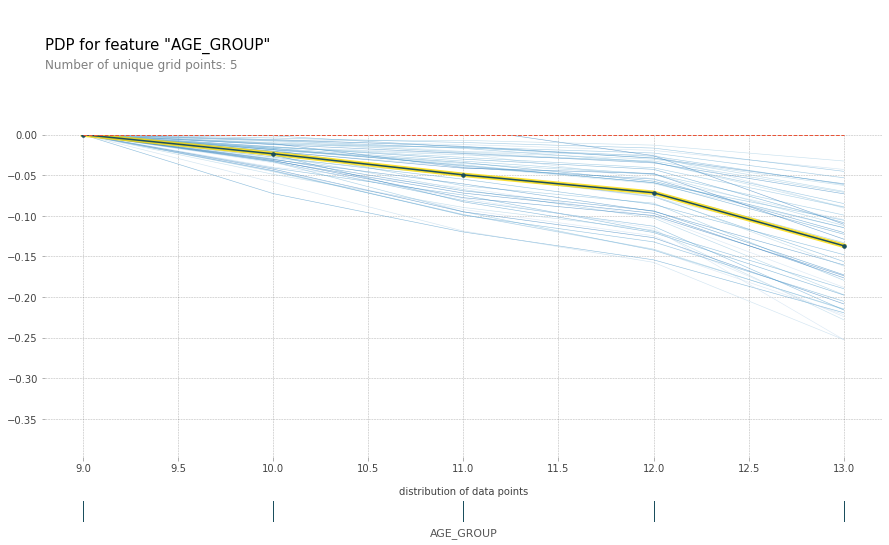

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b1d0a2d90>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b1734f190>})

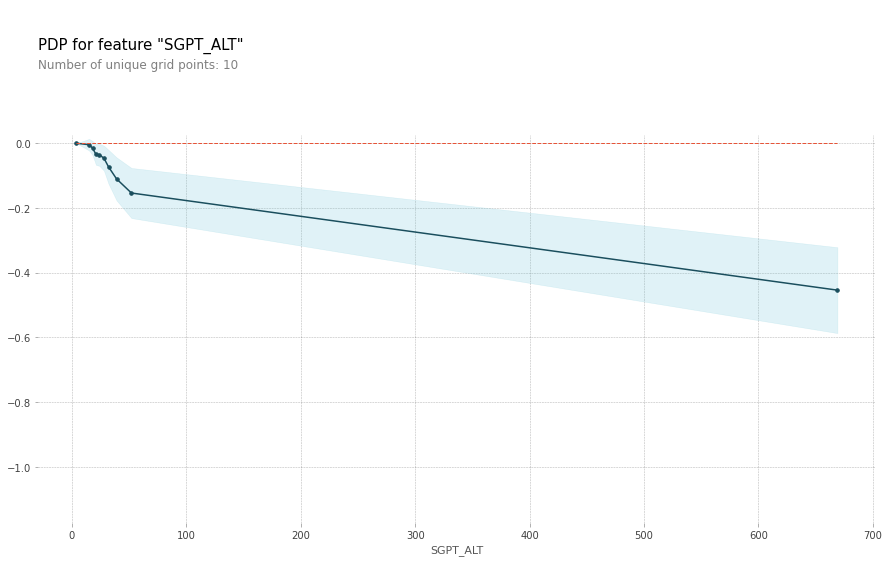

In [ ]:
target_feature = "SGPT_ALT"

isolated = pdp_isolate(
    model=model,
    dataset=X_val_preprocessed_df,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile", 
    num_grid_points=10,  
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18210890>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b182043d0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b1818aa90>}})

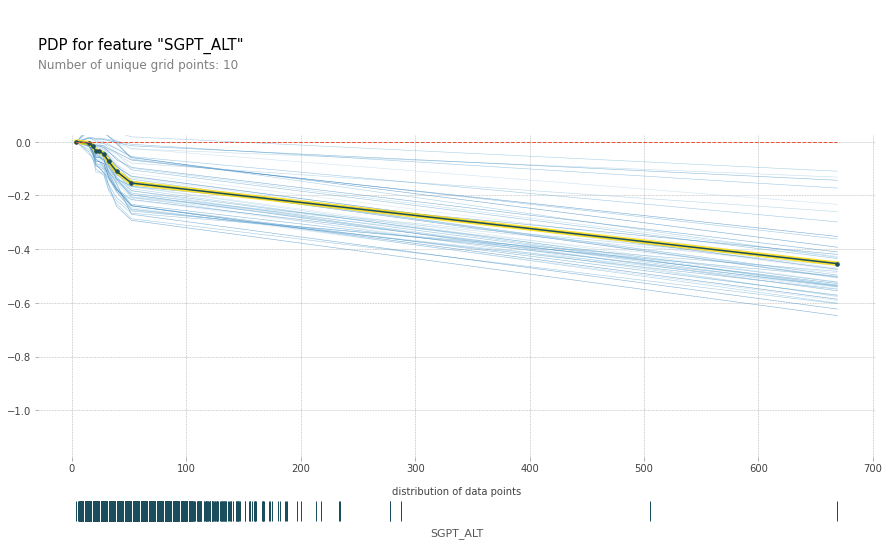

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18ca6190>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18cbef90>})

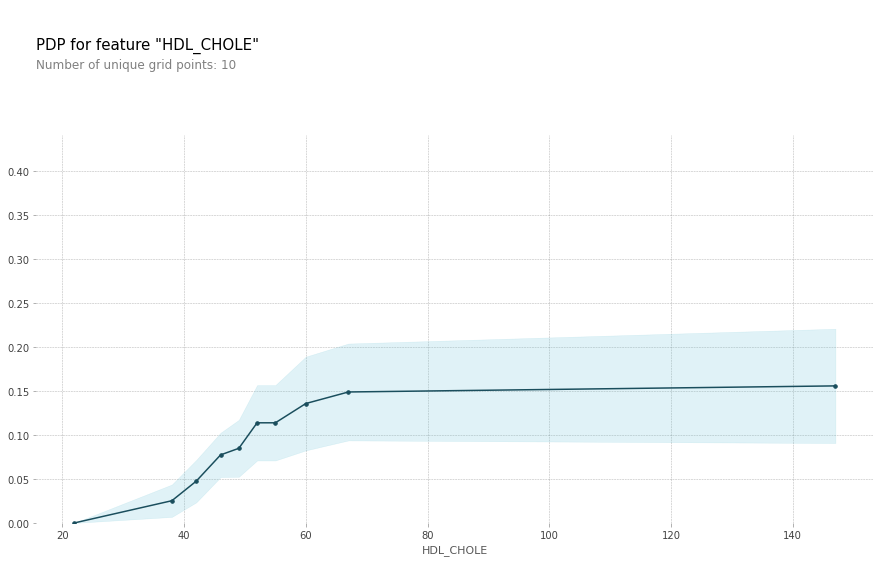

In [ ]:
target_feature = "HDL_CHOLE"

isolated = pdp_isolate(
    model=model,
    dataset=X_val_preprocessed_df,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile", 
    num_grid_points=10,  
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18bd8a90>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b174d89d0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18c15e10>}})

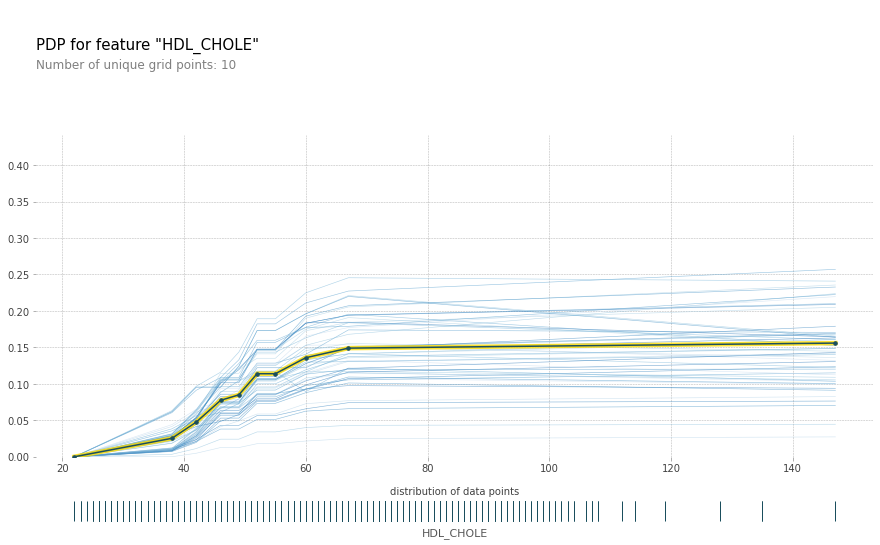

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18297550>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b18d65290>})

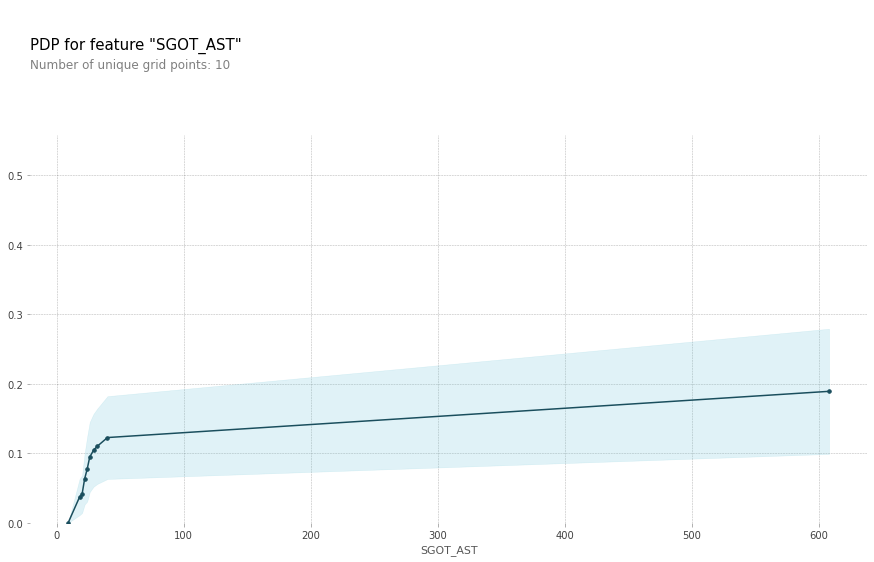

In [ ]:
target_feature = "SGOT_AST"

isolated = pdp_isolate(
    model=model,
    dataset=X_val_preprocessed_df,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile", 
    num_grid_points=10,  
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b17ec0e10>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b1ce97cd0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2b17454150>}})

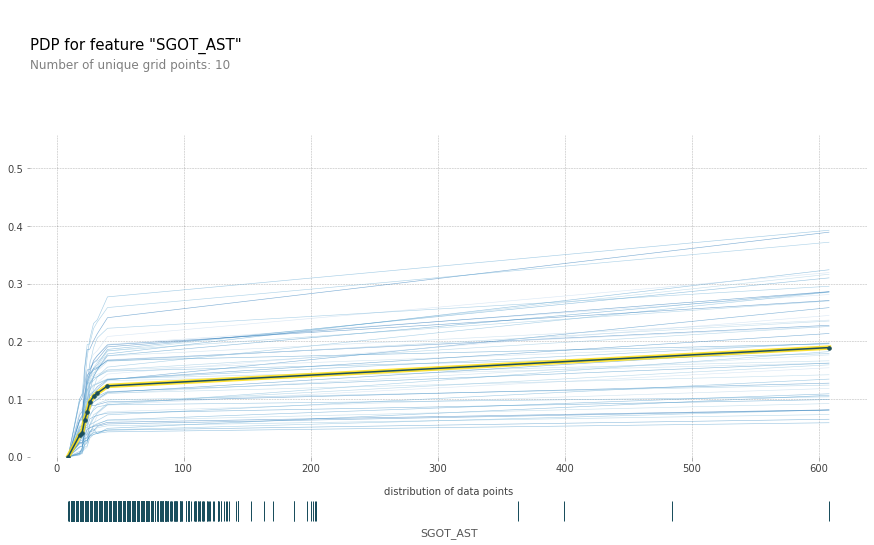

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

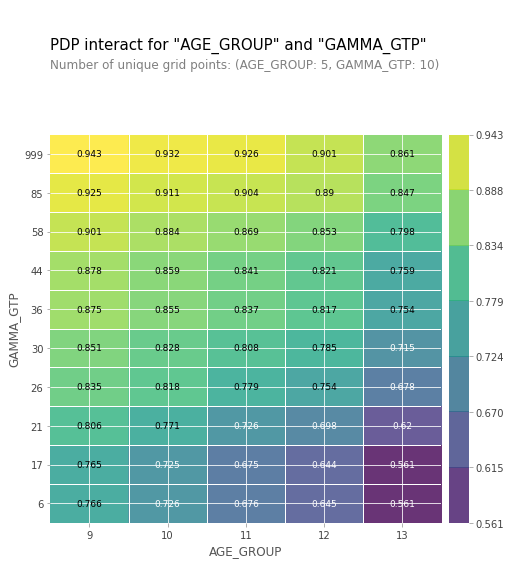

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

target_features = ["AGE_GROUP", "GAMMA_GTP"]

interaction = pdp_interact(
    model=model,
    dataset=X_val_preprocessed_df,
    model_features=X_val.columns,
    features=target_features,
    cust_grid_points=[
        [9, 10, 11, 12, 13],  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        None,  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
# plot_params={'xticks':[encoded_features, original_features]}